In [1]:
import tensorflow as tf
from tensorflow import keras
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
# import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')


# 1 build an auto-encoder model using signals of intact structure

In [18]:
data1_r= pd.read_csv('G:/BaiduNetdiskDownload/data2XQS/downrate8/group1.csv',header=None)
data2_r= pd.read_csv('G:/BaiduNetdiskDownload/data2XQS/downrate8/group2.csv',header=None)
data3_r= pd.read_csv('G:/BaiduNetdiskDownload/data2XQS/downrate8/group3.csv',header=None)
data4_r= pd.read_csv('G:/BaiduNetdiskDownload/data2XQS/downrate8/group4.csv',header=None)

In [20]:
print(data2_r.shape)

(32768, 137)


In [32]:
data1=data1_r.values[0:32700:100,:] #重采样以数据降维，每100个取一个，sf1=sf/100
data2=data2_r.values[0:32700:100,:] 
data3=data3_r.values[0:32700:100,:] 
data4=data4_r.values[0:32700:100,:] 
print(data1.shape)

(327, 86)


In [35]:
#仅用group 1进行训练，即 intact condition
data0=data1_r.values
print(data0.shape)

(32768, 86)


In [37]:
data_r1=data0[0:32700:100,:]
data_r2=data0[1:32700:100,:]
data_r3=data0[2:32700:100,:]
data_r4=data0[3:32700:100,:]
print(data_r1.shape)

(327, 86)


In [42]:
data_temp1=np.append(data_r1,data_r2,axis=1)
data_temp2=np.append(data_r3,data_r4,axis=1)
data_resample=np.append(data_temp1,data_temp2,axis=1).T
print(data_resample.shape)  

(344, 327)


In [ ]:
data_fft=np.fft.fft(data,np.size(data,0),axis=0)/data.size*2  # np.fft.fft默认返回每行的结果
data_fft=np.real(data_fft)
print(np.real(data_fft).shape)
print(np.real(data_fft))

In [ ]:
plt.subplot(2,1,1)
plt.plot(data_fft[0,:])
plt.subplot(2,1,2)
plt.plot(data_fft[1,:])

#### normalized input is crucial to reduce the adverse effect of loadings or ambient excitation

In [43]:
from sklearn.preprocessing import MinMaxScaler
#MinMaxScaler()归一化数据到[0,1]，且默认是对每一列进行归一化。注意到，对于时间序列，此处的目的应该是对每个segment的一行进行归一化
#因此，此处先矩阵转置，归一化后再转置回

scaler = MinMaxScaler()
data_norm_temp=scaler.fit_transform(data_resample.T)
data_norm=data_norm_temp.T
print(data_norm.shape)
print(data_norm)

(344, 327)
[[0.60098667 0.57907503 0.57480359 ... 0.5739911  0.57390848 0.5738952 ]
 [0.60220582 0.57695877 0.56987371 ... 0.57452383 0.57438406 0.57142336]
 [0.60189025 0.57400454 0.56974761 ... 0.57410855 0.57419922 0.57414786]
 ...
 [0.61896744 0.5648305  0.56294099 ... 0.56474652 0.5591478  0.55903596]
 [0.57514659 0.52362805 0.52128452 ... 0.52746429 0.52754451 0.52740305]
 [0.58808309 0.54452497 0.53671904 ... 0.54700086 0.53677342 0.54164788]]


### split the data to train and validate

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_norm, data_norm, test_size=0.25, random_state=0)


In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(258, 327)
(86, 327)
(258, 327)
(86, 327)


In [46]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow import keras.layers
# from tensorflow import keras.layers
input_shape=327
input_img = keras.Input(shape=(input_shape,))
encoded = keras.layers.Dense(input_shape, activation='relu')(input_img)
encoded = keras.layers.Dense(256, activation='relu')(encoded)
encoded = keras.layers.Dense(128, activation='relu')(encoded)
encoded = keras.layers.Dense(64, activation='relu')(encoded)

decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(128, activation='relu')(encoded)
decoded = keras.layers.Dense(256, activation='relu')(decoded)
decoded = keras.layers.Dense(input_shape, activation='sigmoid')(decoded)

In [47]:
autoencoder = keras.Model(input_img, decoded)

opt = keras.optimizers.Adam(lr=0.001)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, baseline=None,restore_best_weights=False)


autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
# autoencoder.compile(optimizer=opt, loss='mse')

history_auto=autoencoder.fit(X_train, y_train,
                epochs=500,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[callback] )

Epoch 1/500
5/5 [==============================] - 0s 29ms/step - loss: 0.6932 - val_loss: 0.6923
Epoch 2/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6918 - val_loss: 0.6901
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6894 - val_loss: 0.6859
Epoch 4/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6850 - val_loss: 0.6796
Epoch 5/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6796 - val_loss: 0.6774
Epoch 6/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6782 - val_loss: 0.6746
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 0.6756 - val_loss: 0.6732
Epoch 8/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6743 - val_loss: 0.6726
Epoch 9/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6734 - val_loss: 0.6727
Epoch 10/500
5/5 [==============================] - 0s 10ms/step - loss: 0.6738 - val_loss: 0.6726
Epoch 11/500
5/5 [=

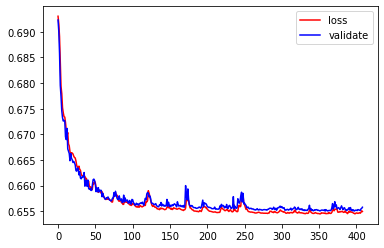

In [48]:
plt.plot(history_auto.history['loss'],'r',label='loss')
plt.plot(history_auto.history['val_loss'],'b',label='validate')

plt.legend()

plt.show()

# 2 reconstruct signals of different damage senarios

Having trained the auto-encoder model using signals of intact structural, series of signlas of different Damage Senarios are then fed into the model to obtain the resconstructed ones.

In [ ]:
data_ds= pd.read_csv('D:/research work/autoencode_damage detection/data/intact2.csv',header=None,skiprows=1,nrows=25600) 
# 25600=200*128
# print(data_ds)

In [ ]:
data_ds=data_ds.values
print(data_ds.shape)

In [ ]:
# ds0=data_ds[::2,0]
# print(ds0.shape)

In [ ]:
# notice that the input data of auto-encoder model is with sf=128Hz and inpu_shape=128
ds0=data_ds[::2,0].reshape(100,128)
ds1=data_ds[::2,1].reshape(100,128)
ds2=data_ds[::2,2].reshape(100,128)
ds3=data_ds[::2,3].reshape(100,128)

print(ds0.shape)
print(ds0)

In [ ]:
ax1=plt.subplot(2,1,1)
plt.plot(ds0[0,:])
plt.subplot(2,1,2)
plt.plot(ds1[0,:])
plt.suptitle('time-domain history of acceleration')

In [ ]:
# 先进行fft变换
ds0_fft=np.real(np.fft.fft(ds0,np.size(ds0,0),axis=0)/ds0.size*2)
ds1_fft=np.real(np.fft.fft(ds1,np.size(ds1,0),axis=0)/ds1.size*2)
ds2_fft=np.real(np.fft.fft(ds2,np.size(ds2,0),axis=0)/ds2.size*2)
ds3_fft=np.real(np.fft.fft(ds3,np.size(ds3,0),axis=0)/ds3.size*2)

print(ds0_fft.shape)
print(ds0_fft)

In [51]:
ds0_=data1_r.values[5:32700:100,:] 
ds1_=data2_r.values[0:32700:100,:] 
ds2_=data3_r.values[0:32700:100,:] 
ds3_=data4_r.values[0:32700:100,:] 
print(ds0.shape)
print(ds1.shape)
print(ds2.shape)
print(ds3.shape)


(327, 86)
(327, 137)
(327, 143)
(327, 179)


In [55]:
# 再进行归一化 （注意函数默认按列归一化）
scaler = MinMaxScaler()
ds0=scaler.fit_transform(ds0_).T
ds1=scaler.fit_transform(ds1).T
ds2=scaler.fit_transform(ds2_).T
ds3=scaler.fit_transform(ds3_).T

print(ds0.shape)


(86, 327)


Text(0.5, 0.98, 'Normalized frequency amplitude of acceleration')

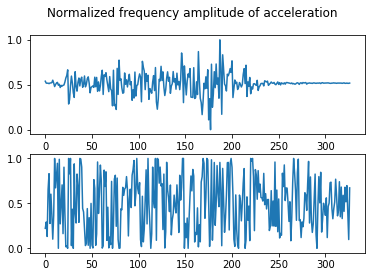

In [56]:
ax1=plt.subplot(2,1,1)
plt.plot(ds0[0,:])
plt.subplot(2,1,2)
plt.plot(ds1[0,:])

plt.suptitle('Normalized frequency amplitude of acceleration')

In [58]:
ds0_re=autoencoder.predict(ds0)
ds1_re=autoencoder.predict(ds1)
ds2_re=autoencoder.predict(ds2)
ds3_re=autoencoder.predict(ds3)

print(ds0_re.shape)


(86, 327)


Hence, we has created 60 samples for IS and each DS 

Text(0.5, 0.98, 'frequency-domain history of original and reconstructed')

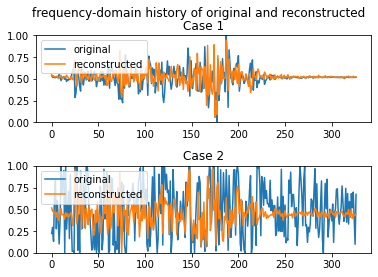

In [61]:
ax1=plt.subplot(2,1,1)
plt.plot(ds0[0,:],label='original')
plt.legend()
plt.plot(ds0_re[0,:],label='reconstructed')
plt.legend()
plt.legend(loc='upper left') 
plt.ylim((0.0,1.0))
ax1.set_title('Case 1')

ax2=plt.subplot(2,1,2)
plt.plot(ds1[0,:],label='original')
plt.plot(ds1_re[0,:],label='reconstructed')
plt.ylim((0.0,1.0))
plt.legend(loc='upper left') 
ax2.set_title('Case 2')

plt.subplots_adjust(wspace =0.2, hspace =0.5)
plt.suptitle('frequency-domain history of original and reconstructed')

Exciting that, a good reconstruction is achieved

# 3 damage-sensitive features extraction 

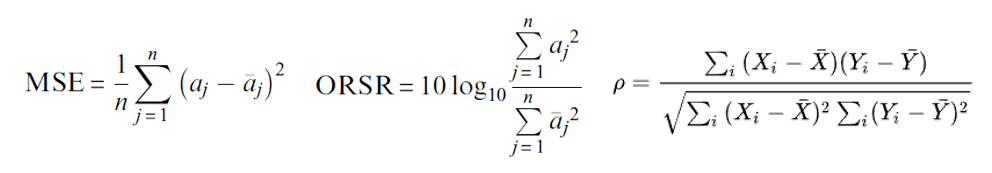

indicator 1: mean squared error _mse

In [62]:
from sklearn.metrics import mean_squared_error

def mse(a1,a2):
    mse=mean_squared_error(a1,a2,multioutput='raw_values',squared=False) 
    return mse

# a1 a2 为矩阵时，按列计算

In [64]:
mse0=mse(ds0.T,ds0_re.T) # 此处转置以匹配函数
mse1=mse(ds1.T,ds1_re.T)
mse2=mse(ds2.T,ds2_re.T)
mse3=mse(ds3.T,ds3_re.T)


print(mse1.shape)

(137,)


indicator2: original-to-reconstructed-signal ratio _orsr

In [65]:
def orsr(a1,a2):
    ret1=np.linalg.norm(a1,axis=0)  #逐列平方和后开方
    ret2=np.linalg.norm(a2,axis=0) 
    orsr=np.log10(ret1**2/ret2**2)
    return orsr

# a1 a2 为矩阵时，按列计算

In [66]:
orsr0=orsr(ds0.T,ds0_re.T) # 此处转置以匹配函数
orsr1=orsr(ds1.T,ds1_re.T)
orsr2=orsr(ds2.T,ds2_re.T)
orsr3=orsr(ds3.T,ds3_re.T)


print(orsr1.shape)

(137,)


indicator3: Pearson product-moment correlation coefficients _corr

In [67]:
# 该函数实现的功能：对两个矩阵a b 分别求其对应行的互相关系数
def correlation(a,b):
    corr=np.array([]) #定义一个空数组用以存放系数
    for x in range(len(a)):
        corr_matrix=np.corrcoef(a[x,:],b[x,:])
        corr_efficient=corr_matrix[0,1]
        corr=np.append(corr,corr_efficient)
    return corr


In [68]:
corr0=correlation(ds0,ds0_re)
corr1=correlation(ds1,ds1_re)
corr2=correlation(ds2,ds2_re)
corr3=correlation(ds3,ds3_re)


print(corr1.shape)

(137,)


append indicators (mse,orsr and corr) to one dataset

In [69]:
MSE=np.append(mse0,mse1,axis=0)    #按行添加
MSE=np.append(MSE,mse2,axis=0)
MSE=np.append(MSE,mse3,axis=0)

print(MSE.shape)

(545,)


In [70]:
ORSR=np.append(orsr0,orsr1,axis=0)    #按行添加
ORSR=np.append(ORSR,orsr2,axis=0)
ORSR=np.append(ORSR,orsr3,axis=0)

print(ORSR.shape)
# print(ORSR)

(545,)


In [71]:
CORR=np.append(corr0,corr1,axis=0)    #按行添加
CORR=np.append(CORR,corr2,axis=0)
CORR=np.append(CORR,corr3,axis=0)

print(CORR.shape)

(545,)


In [72]:
parameter=np.array([MSE,ORSR,CORR]).T
print(parameter.shape)
print(parameter)

(545, 3)
[[ 0.11571781 -0.01082791  0.35899746]
 [ 0.11572091 -0.01123251  0.35846458]
 [ 0.11553528 -0.01270754  0.36072509]
 ...
 [ 0.14065502  0.05359746  0.05298935]
 [ 0.13723148  0.0171557   0.06225447]
 [ 0.13626029  0.01889952  0.077645  ]]


In [ ]:
np.savetxt("D:/research work/autoencode_damage detection/data/parameter.csv", parameter, delimiter=",",fmt='%s')

# 4 straightforward clustering pattern 

In [79]:
# to add the labels
# index0=['IS','DS1','DS2','DS3']

damage_index0=np.repeat('IS',len(ds0)) 
damage_index1=np.repeat('DS1',len(ds1)) 
damage_index2=np.repeat('DS2',len(ds2)) 
damage_index3=np.repeat('DS3',len(ds3)) 
print(damage_index0.shape)
# damage_index=damage_index.reshape(400,1)

# parameter_labeled=np.append(parameter,damage_index,axis=1)
# print(parameter_labeled.shape)
# print(parameter_labeled)

(86,)


In [89]:
index_temp1=np.append(damage_index0,damage_index1,axis=0)
index_temp2=np.append(damage_index2,damage_index3,axis=0)
damage_index=np.append(index_temp1,index_temp2,axis=0)

damage_index=damage_index.reshape(545,1)
print(damage_index.shape)

(545, 1)


In [93]:
parameter_labeled=np.append(parameter,damage_index,axis=1)
print(parameter_labeled.shape)


(545, 4)


In [94]:
df=pd.DataFrame(data=parameter_labeled,columns=['mse','orsr','corr','damage'])

print(df)

                     mse                   orsr                  corr damage
0    0.11571781293032399  -0.010827905042574625   0.35899745739945593     IS
1    0.11572091421989673  -0.011232507553796596    0.3584645771901249     IS
2    0.11553528305286818  -0.012707539472930594    0.3607250895410322     IS
3    0.11539734321294659  -0.010581732188427766   0.35781655569520054     IS
4    0.11530231510085742  -0.011039526396459692   0.35911718736435627     IS
..                   ...                    ...                   ...    ...
540  0.14066006308695939    0.05763896384772906   0.06335060449458971    DS3
541   0.1389115882404357    0.06543541755613226    0.0589257960517645    DS3
542  0.14065501889283827   0.053597463042468735   0.05298935065299886    DS3
543   0.1372314837343932   0.017155697798669618  0.062254471066137754    DS3
544  0.13626028504824003   0.018899515788097464   0.07764500453918367    DS3

[545 rows x 4 columns]


In [96]:
from pathlib import Path  
filepath = Path("G:/BaiduNetdiskDownload/data2XQS/downrate8/feature.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath,index=0)  

In [97]:
data_df= pd.read_csv(filepath)
print(data_df)

          mse      orsr      corr damage
0    0.115718 -0.010828  0.358997     IS
1    0.115721 -0.011233  0.358465     IS
2    0.115535 -0.012708  0.360725     IS
3    0.115397 -0.010582  0.357817     IS
4    0.115302 -0.011040  0.359117     IS
..        ...       ...       ...    ...
540  0.140660  0.057639  0.063351    DS3
541  0.138912  0.065435  0.058926    DS3
542  0.140655  0.053597  0.052989    DS3
543  0.137231  0.017156  0.062254    DS3
544  0.136260  0.018900  0.077645    DS3

[545 rows x 4 columns]


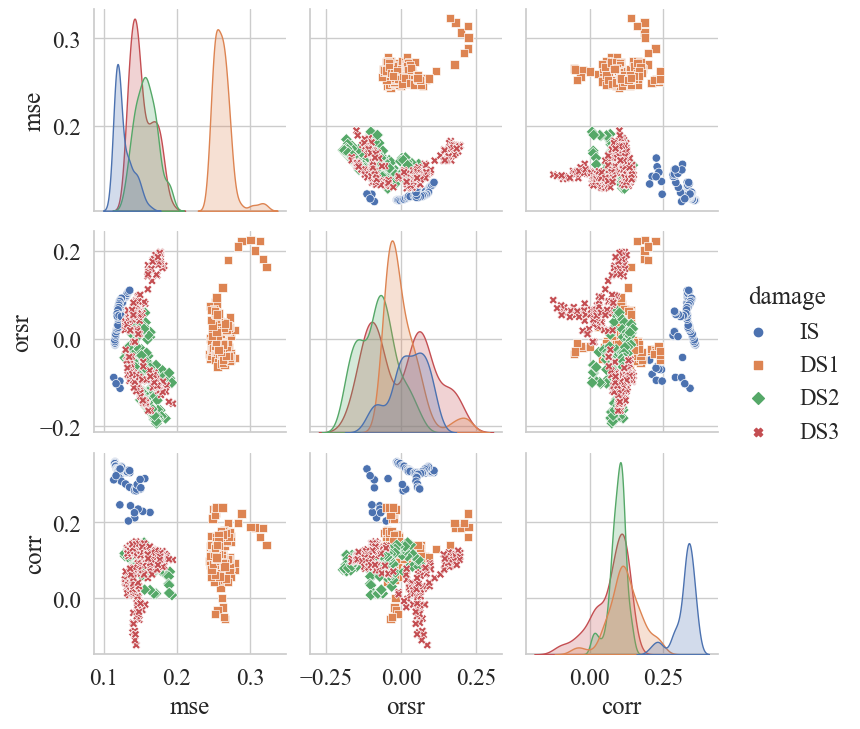

In [98]:
import seaborn as sns
plt.rcParams['figure.dpi'] = 100
sns.set(style='whitegrid',font='Times New Roman',font_scale=1.5)

# sns.pairplot(df,hue="damage", diag_kind="hist",palette="husl")
sns.pairplot(data_df, vars=df.columns[:-1],hue="damage", markers=["o", "s", "D","X"])

omg, explicit cluster, that's exciting ^--^

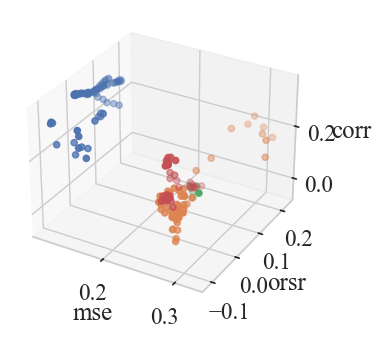

In [102]:
ax=plt.subplot(projection='3d') 

ax.scatter(MSE[0:len(ds0)],ORSR[0:len(ds0)],CORR[0:len(ds0)],label='s')
ax.scatter(MSE[len(ds0):len(ds1)],ORSR[len(ds0):len(ds1)],CORR[len(ds0):len(ds1)],label='a')
ax.scatter(MSE[len(ds1):len(ds2)],ORSR[len(ds1):len(ds2)],CORR[len(ds1):len(ds2)],label='b')
ax.scatter(MSE[len(ds2):len(ds3)],ORSR[len(ds2):len(ds3)],CORR[len(ds2):len(ds3)],label='c')    

ax.set_xlabel('mse')
ax.set_ylabel('orsr')
ax.set_zlabel('corr')

plt.show()


# 5 fuzzy cluster investigation

To investigate whether there existes a straightforward clustering pattern, i.e., unsupervised fuzzy clusters of damage index based on extracted parameters, a Fuzzy-CMeans cluster is performed at the preliminary stage

In [103]:
import random
import sys

Finding minimum and maximum in the given dataset

In [104]:
def find_max(dataset):
  cols = dataset.shape[1]
  max_in_dataset = -sys.maxsize
  for col in range(cols):
    if max(dataset[:, col]) > max_in_dataset:
      max_in_dataset = max(dataset[:, col])
  return max_in_dataset

def find_min(dataset):
  cols = dataset.shape[1]
  min_in_dataset = sys.maxsize
  for col in range(cols):
    if min(dataset[:, col]) < min_in_dataset:
      min_in_dataset = min(dataset[:, col])
  return min_in_dataset

In [105]:
# Randomely choose a value for each dimmension (feature)
def initialize_centroids(dataset, k, minimum, maximum):
  cols = dataset.shape[1]
  centroids = np.array([np.array([random.uniform(minimum, maximum) for col in range(cols)]) for i in range(k)])
  return centroids

# Calculate fuzziness for each point
def update_data_fuzziness(dataset, centroids, m):
  u = np.array([[1 / np.sum([(np.linalg.norm(data - vi) / np.linalg.norm(data - vj)) ** (2 / (m - 1)) for vj in centroids]) for vi in centroids]for data in dataset], dtype='float64')  
  return u

# Modifying means
def modify_centroids(num_centroids, u, dataset, m):
  N = len(dataset)
  centroids = np.array([np.add.reduce([(u[k, i] ** m) * dataset[k] for k in range(N)]) / np.sum([u_[i] ** m for u_ in u]) for i in range(num_centroids)])
  return centroids

Calculating errors

In [106]:
def error_calculator(u, m, dataset, centroids):
  error = np.sum([np.sum([(u[j, i] ** m) * (np.linalg.norm(dataset[j] - centroids[i]) ** 2) 
            for i in range(len(centroids))]) 
      for j in range(len(dataset))])
  return error

Creating the model

In [107]:
def fuzzy_cmeans_model(dataset, k, num_iterations, m):
  minimum = find_min(dataset)
  maximum = find_max(dataset)

  centroids = initialize_centroids(dataset, k, minimum, maximum)

  for i in range(num_iterations):
    u = update_data_fuzziness(dataset, centroids, m)
    centroids = modify_centroids(len(centroids), u, dataset, m)
    error = error_calculator(u, m, dataset, centroids)

  return centroids, u, error

Plotting the results

In [108]:
def plot_results(dataset, u, centroids, k):
  plt.figure(figsize=(8,6))
  plt.scatter(dataset[:, 0], dataset[:, 1])
  for cluster in range(k):
      clusteredData = np.array([dataset[i] for i in range(len(dataset)) 
          if cluster == np.argmax(u[i])])
      #print(clusteredData)
      plt.scatter(clusteredData[:, 0], clusteredData[:, 1])
  plt.scatter(centroids[:, 0], centroids[:, 1], color='black', s=100)
  plt.show()

In [109]:
def label_cluster(dataset, u, centroids, k):
  label = np.ones([len(dataset),2], dtype = int)
  for cluster in range(k):
    for i in range(len(dataset)):
      if cluster == np.argmax(u[i]):
        label[i,0]=i;
        label[i,1]=cluster;
  return label
  np.savetxt('label.csv', label, delimiter = ',',fmt='%d')

In [110]:
def fuzzy_plot(dataset, u, centroids, k):
  plt.figure(figsize=(8,6))
  plt.scatter(dataset[:, 0], dataset[:, 1], c=u)
  plt.scatter(centroids[:, 0], centroids[:, 1], color='black', s=100)

In [ ]:
# np.savetxt('label.csv', label, delimiter = ',',fmt='%d')

In [111]:
# parameter=df[['mse','orsr','corr']].values
print(parameter.shape)
print(parameter)

(545, 3)
[[ 0.11571781 -0.01082791  0.35899746]
 [ 0.11572091 -0.01123251  0.35846458]
 [ 0.11553528 -0.01270754  0.36072509]
 ...
 [ 0.14065502  0.05359746  0.05298935]
 [ 0.13723148  0.0171557   0.06225447]
 [ 0.13626029  0.01889952  0.077645  ]]


Impleneting algorithm for parameter

In [112]:
errors = []

for i in range(1,6):
  centroids, u, error = fuzzy_cmeans_model(dataset=parameter, k=i, num_iterations=100, m=2)
  errors.append(error)

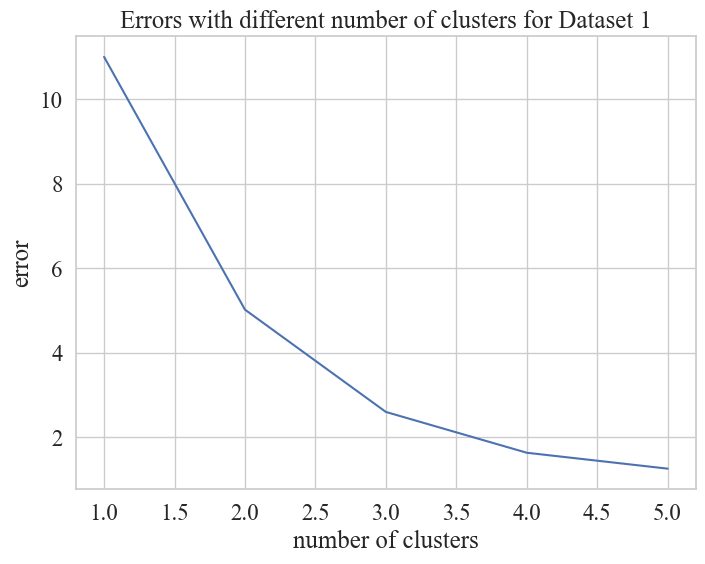

In [113]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(1, 6), errors)
plt.title('Errors with different number of clusters for Dataset 1')
plt.xlabel('number of clusters')
plt.ylabel('error')
plt.show()

We can see that k=4 is a good choice for number of clusters because error redauction rate is very low after that.

In [114]:
centroids, u, error = fuzzy_cmeans_model(dataset=parameter, k=4, num_iterations=100, m=2)

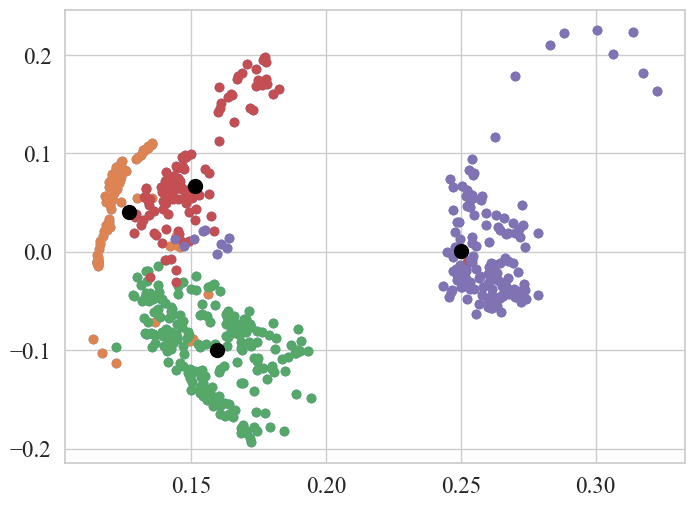

In [115]:
plot_results(parameter, u, centroids, k=4)

In [116]:
damage=label_cluster(parameter, u, centroids, k=4)
# np.savetxt('label.csv', label, delimiter = ',',fmt='%d')

(545, 2)


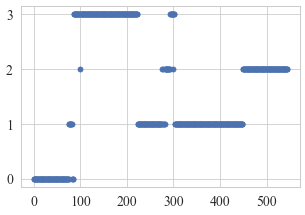

In [117]:
# print(damage)
print(damage.shape)
plt.rcParams['figure.dpi'] =60
plt.scatter(damage[:,0],damage[:,1])

It turns to be a satisfactory outcome, indicating that fyzzy cluster approach can obtain satisfying results.
Hence,  supervised machined learning algorithms are further allocated for identification 

# 6 Supervised machine learning identification

In [118]:
X = parameter
y=damage_index


In [119]:
# y.head()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import plot_confusion_matrix


In [121]:
from sklearn.model_selection import train_test_split

classifiers = [GaussianNB(), 
               KNeighborsClassifier(n_neighbors=5),
               LogisticRegression(solver="liblinear", random_state=0),
               SVC(probability=True, random_state=0),
               DecisionTreeClassifier(random_state=0),
               RandomForestClassifier(random_state=0),
               AdaBoostClassifier(n_estimators=100, random_state=0),
               GradientBoostingClassifier(random_state=0),
               MLPClassifier(random_state=0)]

for cls in classifiers:
    cls.fit(X_train, y_train)

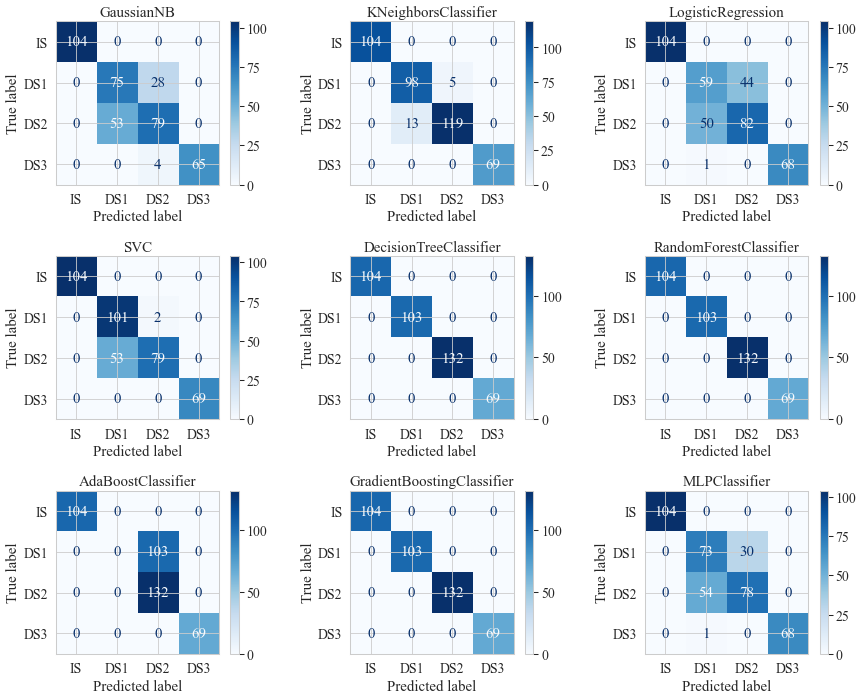

In [122]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,12))
for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='Blues',
                        display_labels=['IS','DS1','DS2','DS3'])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()
# plt.savefig('shap.png', dpi=1200)

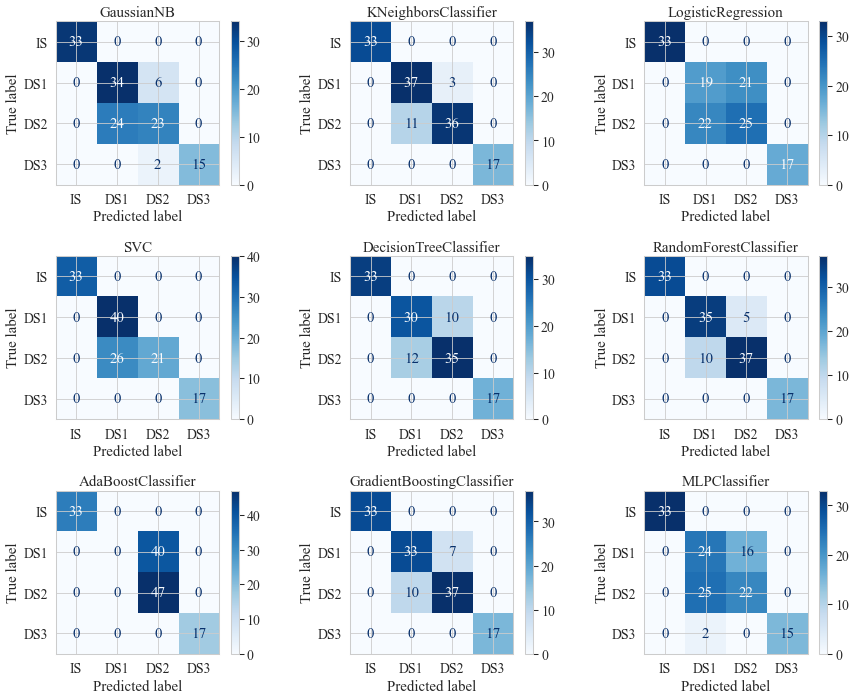

In [123]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,12))
plt.rcParams['figure.dpi'] =300
for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues',
                        display_labels=['IS','DS1','DS2','DS3'])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()
# plt.savefig('test_raw.png', dpi=1200)

In [126]:
# from sklearn.tree import DecisionTreeClassifier

rf=RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
print('Accuracy  on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy  on training set: 1.00
Accuracy on test set: 0.89


In [ ]:
params2={
#    'learning_rate':np.linspace(0.05,0.25,5), 
    'criterion': ['gini','entropy'],
    'splitter':['best',random],
    'max_depth':[x for x in range(2,16,2)], 
    'min_samples_split':[x for x in range(1,5,1)],
    'min_samples_leaf':[x for x in range(1,5,1)],
    'max_features': ['auto', 'sqrt','log2'] }

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
print('Accuracy classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))